# Imports

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

%matplotlib inline

#print(tf.__version__)

# Carregamento de dados

In [67]:
%run "datasets/parse.ipynb"
train_df = parse_train("")
test_df = parse_test("")

# SEED utilizada

In [68]:
SEED = 2022

# Preparação dos dados

In [69]:
categorical_to_numerical = {
    'Injecao na rede (kWh)': {
        'None': 0,
        'Low': 1,
        'Medium': 2,
        'High':3,
        'Very High':4
    },
    'weather_description': {
        'overcast clouds': 0,
        'scattered clouds': 1,
        'few clouds': 2,
        'sky is clear': 3,
        'broken clouds': 4,
        'light rain': 5,
        'moderate rain': 6,
        'heavy intensity rain':7
    }
}

numeric_columns = ['Hora', 'Normal (kWh)', 'Horario Economico (kWh)', 'Autoconsumo (kWh)', 'temp','feels_like','temp_min','temp_max','pressure','humidity', 'wind_speed','clouds_all','rain_1h']


In [70]:
def neural_network_data_preparation(df: pd.DataFrame,test_or_train) -> pd.DataFrame:
    prep_df= df
    prep_df['rain_1h'] = prep_df['rain_1h'].replace('', '0')
    prep_df['rain_1h'] = pd.to_numeric(prep_df['rain_1h'])
            
    ### Converter as features categoricas em numericas
    prep_df.replace(categorical_to_numerical, inplace=True)

    ### Extrair a hora e dia da semana da feature 'record_date'
    record_date = pd.DatetimeIndex(prep_df['Data'])

    prep_df['Month'] = record_date.month
    prep_df['Day'] = record_date.day
    prep_df['Year'] = record_date.year

    dropped_columns = ['grnd_level','sea_level','dt','Data','city_name']
    prep_df = prep_df.drop(dropped_columns, axis=1)

    prep_df.loc[(prep_df['Hora'] < 6) & (prep_df['Hora'] > 21), 'Injecao na rede (kWh)'] = 0

    

   
    ### Limites superior e inferior (sem outliers) dos diagramas de caixa
    whiskers = []
    for num in numeric_columns:
        Q1 = prep_df[num].quantile(0.25)
        Q3 = prep_df[num].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        whiskers.append((num,lower,upper))

    ### Tratar os outliers das features numéricas:
    ### Substituir os valores dos outliers pela mediana
    if(train_test_split == "train"):
        for num, lower, upper in whiskers:
            prep_df = prep_df[(prep_df[num] >= lower) & (prep_df[num] <= upper)]

    return prep_df

In [71]:
X = neural_network_data_preparation(train_df,"train")

In [72]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Hora                     11016 non-null  int64  
 1   Normal (kWh)             11016 non-null  float64
 2   Horario Economico (kWh)  11016 non-null  float64
 3   Autoconsumo (kWh)        11016 non-null  float64
 4   Injecao na rede (kWh)    11016 non-null  int64  
 5   temp                     11016 non-null  float64
 6   feels_like               11016 non-null  float64
 7   temp_min                 11016 non-null  float64
 8   temp_max                 11016 non-null  float64
 9   pressure                 11016 non-null  int64  
 10  humidity                 11016 non-null  int64  
 11  wind_speed               11016 non-null  float64
 12  rain_1h                  11016 non-null  float64
 13  clouds_all               11016 non-null  int64  
 14  weather_description   

In [73]:
y = X['Injecao na rede (kWh)']

X.drop(columns=['Injecao na rede (kWh)'], inplace=True)

In [74]:
scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_scaled = pd.DataFrame(scaler_X.transform(X[X.columns]), columns=X.columns)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=SEED)

# Construção da estrutura da rede neuronal

In [76]:
from keras import regularizers
from tensorflow import keras

optimizer = keras.optimizers.Adam(learning_rate=0.001)


def build_model():
    model = keras.Sequential()

    model.add(Dense(16, input_dim=12, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001),
                    ))  # Input Layer

    model.add(Dense(8, activation="relu",
                    kernel_regularizer=regularizers.l2(0.001),
                    ))

    model.add(Dense(5, activation='softmax',
                    kernel_regularizer=regularizers.l2(0.001),
                    ))  # Output Layer

    # Model compilation
    model.compile(loss=SparseCategoricalCrossentropy(), optimizer=optimizer,
                  #keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    return model


In [77]:
model = build_model()

In [78]:
EPOCHS = 500
BATCH_SIZE = 100

In [79]:
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/500


89/89 [==============================] - 1s 2ms/step - loss: 1.2540 - accuracy: 0.5825
Epoch 2/500
89/89 [==============================] - 0s 3ms/step - loss: 0.9215 - accuracy: 0.7074
Epoch 3/500
89/89 [==============================] - 0s 3ms/step - loss: 0.7892 - accuracy: 0.7199
Epoch 4/500
89/89 [==============================] - 0s 3ms/step - loss: 0.6963 - accuracy: 0.7335
Epoch 5/500
89/89 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.7519
Epoch 6/500
89/89 [==============================] - 0s 2ms/step - loss: 0.5813 - accuracy: 0.7699
Epoch 7/500
89/89 [==============================] - 0s 3ms/step - loss: 0.5486 - accuracy: 0.7803
Epoch 8/500
89/89 [==============================] - 0s 2ms/step - loss: 0.5255 - accuracy: 0.7889
Epoch 9/500
 1/89 [..............................] - ETA: 0s - loss: 0.4674 - accuracy: 0.8300

KeyboardInterrupt: 

-------
-------
-------

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

69/69 [==============================] - 1s 2ms/step - loss: 0.3077 - accuracy: 0.8657


In [ ]:
predicts = model.predict(X_test)

categories_predicted = [np.argmax(pred) for pred in predicts]

69/69 [==============================] - 0s 2ms/step


In [ ]:
predicts[:5]

array([[2.5347552e-01, 5.3625315e-01, 2.1008217e-01, 1.8900410e-04,
        8.6829005e-10],
       [9.9779308e-01, 2.1591189e-03, 4.7859110e-05, 2.3260043e-11,
        5.5335697e-24],
       [9.9985671e-01, 1.4294228e-04, 4.4528767e-07, 4.1468410e-13,
        1.2523279e-22],
       [8.2364571e-01, 1.5134679e-01, 2.5004238e-02, 3.2115397e-06,
        6.1146572e-15],
       [6.1826313e-01, 2.9423425e-01, 8.7473184e-02, 2.9400686e-05,
        2.5743273e-12]], dtype=float32)

In [81]:
print(f1_score(y_test,categories_predicted, average='macro'))
print(f1_score(y_test,categories_predicted, average='micro'))
print(f1_score(y_test,categories_predicted, average='weighted'))


0.6468612336525097
0.8656987295825771
0.8613855114289034


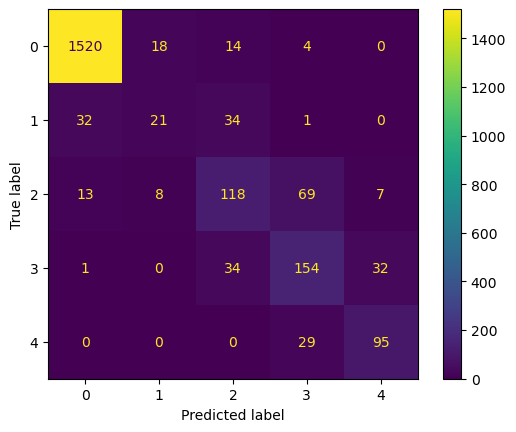

In [80]:
ConfusionMatrixDisplay.from_predictions(y_test,categories_predicted)

# Obter as previsões no dataset de submissão

In [ ]:
#test_df.info()
X = neural_network_data_preparation(test_df,"test")
X.drop(columns=['Injecao na rede (kWh)'], inplace=True)

scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_scaled = pd.DataFrame(scaler_X.transform(X[X.columns]), columns=X.columns)

X_scaled

,Hora,Normal (kWh),Horario Economico (kWh),Autoconsumo (kWh),temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description,Month,Day,Year
0,0.000000,0.000000,0.168531,0.000000,0.040369,0.048576,0.045798,0.034201,0.433333,0.9625,0.186275,0.583072,1.0,0.857143,0.0,0.0,0.0
1,0.043478,0.000000,0.208228,0.000000,0.042253,0.050646,0.048194,0.035794,0.400000,0.9625,0.201961,0.510972,1.0,0.857143,0.0,0.0,0.0
2,0.086957,0.000000,0.124865,0.000000,0.042454,0.050846,0.048363,0.038913,0.366667,0.9625,0.270588,0.382445,1.0,0.857143,0.0,0.0,0.0
3,0.130435,0.000000,0.097438,0.000000,0.042656,0.051080,0.043402,0.038913,0.333333,0.9625,0.344118,0.272727,1.0,0.857143,0.0,0.0,0.0
4,0.173913,0.000000,0.090942,0.000000,0.042589,0.051013,0.043402,0.038913,0.300000,0.9625,0.437255,0.177116,1.0,0.857143,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,0.826087,0.281869,0.000000,0.010336,0.983819,0.982773,0.979514,0.990374,0.300000,0.3125,0.187255,0.000000,0.0,0.428571,1.0,0.1,0.0
2252,0.869565,0.270630,0.000000,0.000000,0.976250,0.975295,0.972764,0.982408,0.333333,0.4250,0.189216,0.000000,0.0,0.428571,1.0,0.1,0.0
2253,0.913043,0.141674,0.000000,0.000000,0.962760,0.961373,0.964428,0.973493,0.366667,0.5375,0.203922,0.000000,0.0,0.428571,1.0,0.1,0.0
2254,0.956522,0.000000,0.179358,0.000000,0.953711,0.952092,0.958657,0.963019,0.366667,0.6250,0.241176,0.000000,0.0,0.428571,1.0,0.1,0.0


In [ ]:
categories_prob_predictions = model.predict(X_scaled)


71/71 [==============================] - 0s 2ms/step


In [ ]:
numerical_predictions = [np.argmax(pred) for pred in categories_prob_predictions]

numerical_predictions[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
predictions_df = pd.DataFrame(numerical_predictions)

numerical_to_categorical = {
    0: {
        0 : 'None',
        1 : 'Low',
        2 : 'Medium',
        3 : 'High',
        4 : 'Very High'
    }
}


predictions_df.replace(numerical_to_categorical, inplace=True)

In [ ]:
predictions_df.index += 1

predictions_df.to_csv("submission.csv", header=['Result'], index_label='RowId')